# Visualizing LFP Responses to Stimulus
A very useful view when working with ecephys data is the **LFP trace**. LFP, or Local Field Potential, is the electrical potential recorded in the extracellular space in brain tissue, and represents activity in regions of neurons. This is particularly useful when you examine LFP responses to stimulus events. The type of stimulus can vary, but in order to visualize this, you must have access to the times of the stimulus events you're interested in. In this notebook, you can extract data from a stimulus nwb file and an LFP nwb file. Importantly, since the stimulus timestamps and the LFP timestamps are not likely to be aligned with each other and in perfectly regular intervals, they must be interpolated.

### Environment Setup

In [1]:
from pynwb import NWBHDF5IO
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import sqrt
from dandi import dandiapi

### Downloading NWB Files
If you don't already have files to analyze, you can use data from The Allen Institute's `Visual Coding - Neuropixels` dataset. If you want to choose your own files to download, set `dandiset_id`, `dandi_stim_filepath`, `dandi_lfp_filepath` accordingly.

In [2]:
dandiset_id = "000021"
dandi_stim_filepath = "sub-699733573/sub-699733573_ses-715093703.nwb"
dandi_lfp_filepath = "sub-699733573/sub-699733573_ses-715093703_probe-810755797_ecephys.nwb"
download_loc = "~/data"

In [3]:
stim_filename = dandi_stim_filepath.split("/")[-1]
lfp_filename = dandi_lfp_filepath.split("/")[-1]
my_dandiset = dandiapi.DandiAPIClient().get_dandiset(dandiset_id)
print(f"Got dandiset {my_dandiset}")

A newer version (0.46.6) of dandi/dandi-cli is available. You are using 0.46.3


Got dandiset DANDI:000021/draft


In [ ]:
file = my_dandiset.get_asset_by_path(dandi_stim_filepath)
# this may take awhile, especially if the file to download is large
file.download(f"{download_loc}/{stim_filename}")

print(f"Downloaded file to {download_loc}/{stim_filename}")

In [ ]:
file = my_dandiset.get_asset_by_path(dandi_lfp_filepath)
# this may take awhile, especially if the file to download is large
file.download(f"{download_loc}/{lfp_filename}")

print(f"Downloaded file to {download_loc}/{lfp_filename}")

### Reading Data from Files
Below you can read in the stimulus file from a filepath you specify. You can extract the `LFP.data` and associated `LFP.timestamps` from an LFP file as well. If you didn't download new nwb files, you'll have to set the value of `stim_filepath` and `lfp_filepath`. In this example, the lfp information is stored in an item called `probe_810755797_lfp_data`, but it may be named differently if you are using a different nwb file.

In [4]:
stim_filepath = f"{download_loc}/{stim_filename}"

In [5]:
stim_io = NWBHDF5IO(stim_filepath, mode="r", load_namespaces=True)
stim_file = stim_io.read() 

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [6]:
lfp_filepath = f"{download_loc}/{lfp_filename}"

In [7]:
lfp_io = NWBHDF5IO(lfp_filepath, mode="r", load_namespaces=True)
lfp_file = lfp_io.read()
lfp_file.acquisition.keys()

dict_keys(['probe_810755797_lfp', 'probe_810755797_lfp_data'])

In [8]:
lfp = lfp_file.acquisition["probe_810755797_lfp_data"]

### Extracting Stimulus Times
First, you must take the stimulus table from your stimulus file. Since your stimulus table will be unique to your experiment, you'll have to use some ingenuity to extract the timestamps that are of interest to you. Below, we display your stimulus names. Set `stim_name` to be the name that contains the associated stimulus table you want. Then we display the stimulus table. You can see that it contains the `start_time` of each stimulus event. In the commented cell below showing `extract timestamps for given stimulus frame`, you should write code to iterate through this table and filter all but the rows that contain an important stimulus event. The output should be a list of timestamps.

In [9]:
stimulus_names = list(stim_file.intervals.keys())
print(stimulus_names)

['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations']


In [10]:
stim_name = "static_gratings_presentations"
stim_table = stim_file.intervals[stim_name]
stim_table[:]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,5381.988653,5382.238857,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.5,"[250.0, 250.0]",deg,6.0,120.0,0.32,0.8,[stimulus_time_interval],"[(49432, 1, timestamps pynwb.base.TimeSeries a..."
1,5382.238857,5382.489060,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.5,"[250.0, 250.0]",deg,6.0,150.0,0.08,0.8,[stimulus_time_interval],"[(49433, 1, timestamps pynwb.base.TimeSeries a..."
2,5382.489060,5382.739264,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.5,"[250.0, 250.0]",deg,6.0,60.0,0.32,0.8,[stimulus_time_interval],"[(49434, 1, timestamps pynwb.base.TimeSeries a..."
3,5382.739264,5382.989467,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.75,"[250.0, 250.0]",deg,6.0,120.0,0.04,0.8,[stimulus_time_interval],"[(49435, 1, timestamps pynwb.base.TimeSeries a..."
4,5382.989467,5383.239686,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.0,"[250.0, 250.0]",deg,6.0,150.0,0.02,0.8,[stimulus_time_interval],"[(49436, 1, timestamps pynwb.base.TimeSeries a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,9133.889309,9134.139517,static_gratings,14.0,"[1.0, 1.0, 1.0]",None,1.0,0.75,"[250.0, 250.0]",deg,6.0,60.0,0.04,0.8,[stimulus_time_interval],"[(70383, 1, timestamps pynwb.base.TimeSeries a..."
5996,9134.139517,9134.389719,static_gratings,14.0,"[1.0, 1.0, 1.0]",None,1.0,0.0,"[250.0, 250.0]",deg,6.0,90.0,0.02,0.8,[stimulus_time_interval],"[(70384, 1, timestamps pynwb.base.TimeSeries a..."
5997,9134.389719,9134.639920,static_gratings,14.0,"[1.0, 1.0, 1.0]",None,1.0,0.0,"[250.0, 250.0]",deg,6.0,60.0,0.08,0.8,[stimulus_time_interval],"[(70385, 1, timestamps pynwb.base.TimeSeries a..."


In [11]:
### extract timestamps for given stimulus frame

filtered_stim_rows = []
for i in range(len(stim_table)):
    if stim_table.orientation[i] == 150.0:
        filtered_stim_rows.append(stim_table[i])
    
all_stim_timestamps = [float(row.start_time) for row in filtered_stim_rows]
print(all_stim_timestamps)

[5382.238856576834, 5382.989467497215, 5385.49156021696, 5386.492395216961, 5386.992817497215, 5388.243861576834, 5390.745951357088, 5390.996157497214, 5392.497405216961, 5393.748469076833, 5393.998682936706, 5395.750134076833, 5397.001177497215, 5397.5015952169615, 5397.751804076835, 5398.002012936707, 5398.252219076834, 5400.2539015768325, 5403.256388857088, 5403.5066002169615, 5403.7568115768345, 5404.0070229367075, 5404.257231576834, 5406.0087129367075, 5406.5091202169615, 5407.760154076834, 5408.7610038570865, 5409.011217497215, 5411.263096357086, 5411.51330521696, 5411.7635140768325, 5414.015352936706, 5414.7660088570865, 5417.518330216961, 5419.770186576833, 5420.771033857087, 5422.022082936706, 5422.772708857088, 5424.774376357088, 5425.2747913570865, 5429.278146357086, 5430.0287729367055, 5434.282304076834, 5438.035482936706, 5439.286488857088, 5440.287309076834, 5440.5375252169615, 5441.037957497214, 5448.043812936708, 5448.54423521696, 5449.044657497214, 5451.54675521696, 54

### Selecting a Period
Oftentimes, the LFP data can be very large. Depending on the machine this analysis is performed on, there may not be enough memory to perform this interpolation. This can be mitigated in two ways. Firstly, the `interp_hz` variable in the following section can be decreased. Otherwise, the analysis can be performed with some smaller period of time within the LFP data. If you wish to do this, set `period_start` and `period_end` to be reasonable times (in seconds) within the experiment to look at. Below are printed the first and last timestamps from the stimulus data and LFP data to inform this choice.

In [12]:
print(all_stim_timestamps[0])
print(all_stim_timestamps[-1])
print(lfp.timestamps[0])
print(lfp.timestamps[-1])

5382.238856576834
9133.138682936707
28.82399658853398
9616.024894403303


In [13]:
# period_start = lfp.timestamps[0]
period_start = 5000
# period_end = lfp.timestamps[-1]
period_end = 8000

In [14]:
# filter stim_timestamps to just timestamps within period
stim_timestamps = np.array([ts for ts in all_stim_timestamps if ts >= period_start and ts <= period_end])

# find indices within lfp data that correspond to period bounds
period_start_idx, period_end_idx = None, None
for i, ts in enumerate(lfp.timestamps):
    if not period_start_idx and ts >= period_start:
        period_start_idx = i
    if period_start_idx and ts >= period_end:
        period_end_idx = i
        break

if period_start_idx == None or period_end_idx == None:
    raise ValueError("Period bounds not found within lfp data")

# get slice of LFP data corresponding to the period bounds
lfp_timestamps = lfp.timestamps[period_start_idx:period_end_idx]
lfp_data = lfp.data[period_start_idx:period_end_idx]

In [15]:
print(stim_timestamps.shape)
print(lfp.timestamps.shape)
print(lfp.data.shape)
print(lfp_timestamps.shape)
print(lfp_data.shape)

(601,)
(10715666,)
(10715666, 93)
(3749994,)
(3749994, 93)


### LFP Interpolation
After you have a valid list of stimulus timestamps, you can generate a linearly-spaced timestamp array called `time_axis`, and interpolate the LFP data along it, making interpolated LFP data called `interp_lfp`. This should be a 2D array with dimensions `time` and `channel`, where channels are the different measurement channels along the probe. Here, the timestamps are interpolated to 1000 Hz, but you can change this by setting `interp_hz`.

In [16]:
interp_hz = 1000

In [17]:
print(lfp_timestamps.shape)
print(lfp_data.shape)

(3749994,)
(3749994, 93)


In [28]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(0, lfp_timestamps[-1], step=(1/interp_hz))
interp_channels = []

for channel in range(lfp_data.shape[1]):
    f = interpolate.interp1d(lfp_timestamps, lfp_data[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_channels.append(f(time_axis))
    
interp_lfp = np.transpose(interp_channels)
    
print(interp_lfp.shape)

(8000000, 93)


### Getting Stimulus Time Windows
Now that you have your interpolated LFP data, you can use the stimulus times to identify the windows of time in the LFP data that exist around a stimulus event. Set `start_time` to be a negative number, representing the seconds before the stimulus event and `end_time` to be number of seconds afterward. Then the `windows` array will be generated as a set of slices of the `interp_lfp` trace by using `interp_hz` to convert seconds to array indices. These will be averaged out for each measurement channel, and a confidence interval will be calculated.

In [29]:
start_time = -0.02
end_time = 0.2

In [30]:
# validate window bounds
if start_time > 0:
    raise ValueError("start time must be non-positive number")
if end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
i = 0
for stim_ts in stim_timestamps:
    i += 0
    # convert time to index
    start_idx = int((stim_ts+start_time) * interp_hz)
    end_idx = int((stim_ts+end_time) * interp_hz)
 
    # bounds checking
    if start_idx < 0 or end_idx > len(interp_lfp)-1:
        continue
        
    windows.append(interp_lfp[start_idx:end_idx])
    

windows = np.array(windows)
print(windows.shape)

(601, 220, 93)


In [31]:
# get average of all windows

average_trace = np.average(windows, axis=0)
print(average_trace.shape)

# get standard error of the mean for confidence interval

n = windows.shape[1]
ci = np.std(windows, axis=0) / sqrt(n)
print(ci.shape)

(220, 93)
(220, 93)


### Visualizing LFP Traces
Now you have the averaged LFP traces for each channel. Below are three views of the same data. There are many channels to view, so for convenience, you can view just a subset of all the channels. You can set `start_channel` and `end_channel` to the bounds of the subset you want to view.

In [32]:
# number of channels
print(average_trace.shape[1])

93


In [33]:
# start_channel = 0
# end_channel = average_trace.shape[1]
start_channel = 40
end_channel = 80
n_channels = end_channel - start_channel

#### Traces from Channels Overlaid

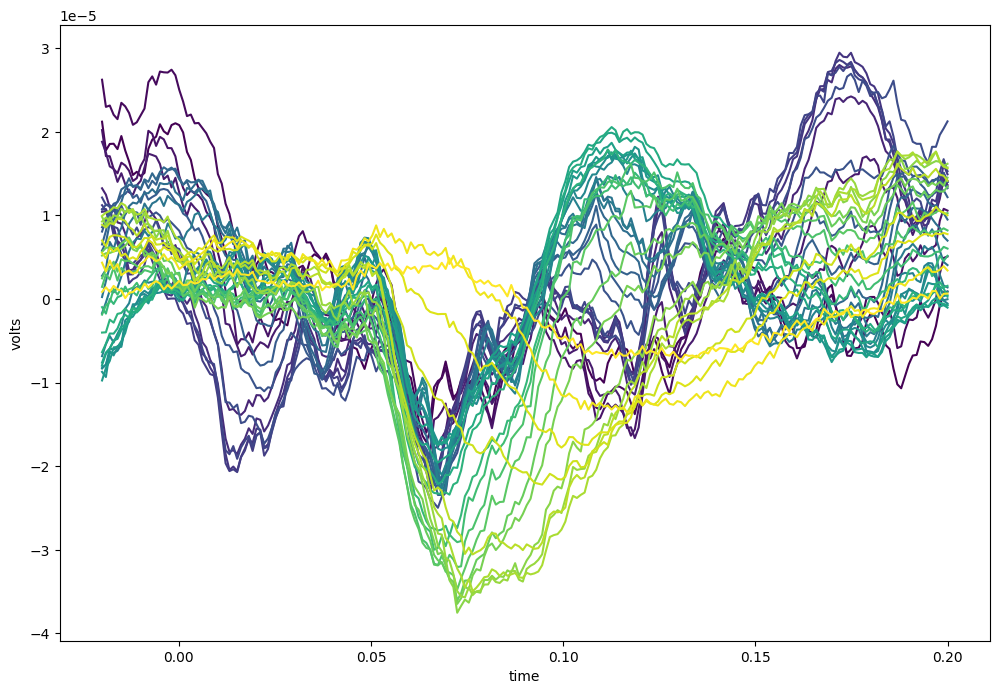

In [34]:
%matplotlib inline

xaxis = np.linspace(start_time, end_time, len(average_trace))
fig, ax = plt.subplots(figsize=(12,8))
colors = plt.cm.viridis(np.linspace(0, 1, n_channels))
ax.set_prop_cycle(color=colors)
ax.plot(xaxis, average_trace[:,start_channel:end_channel])

plt.xlabel("time")
plt.ylabel("volts")
plt.show()

#### Traces from Channels Stacked

In [35]:
# Change this if the visualization below looks messy. The larger value the flatter
amp_res = 0.00001

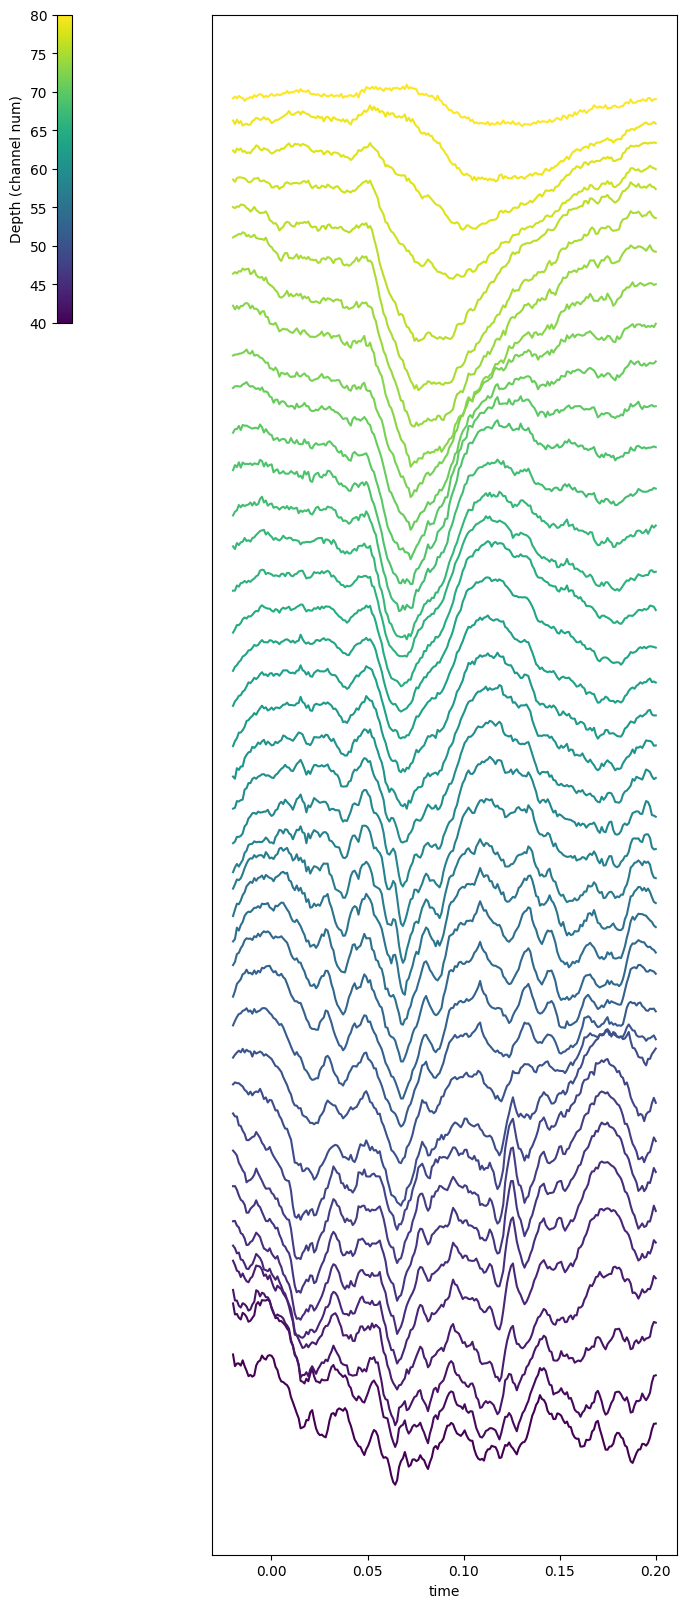

In [36]:
%matplotlib inline

xaxis = np.linspace(start_time, end_time, len(average_trace))
colors = plt.cm.viridis(np.linspace(0, 1, n_channels))
fig, ax = plt.subplots(figsize=(8, n_channels/2))

for i, channel in enumerate(range(start_channel, end_channel)):
    offset_trace = average_trace[:,channel] + i*amp_res
    plot = ax.plot(xaxis, offset_trace, color=colors[i])

norm = mpl.colors.Normalize(vmin=start_channel, vmax=end_channel)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), location="left", anchor=(0,1), shrink=0.2, ax=ax, label='Depth (channel num)')
ax.yaxis.set_ticks([])
plt.xlabel("time")
plt.show()

#### Traces from Channels with Confidence Intervals

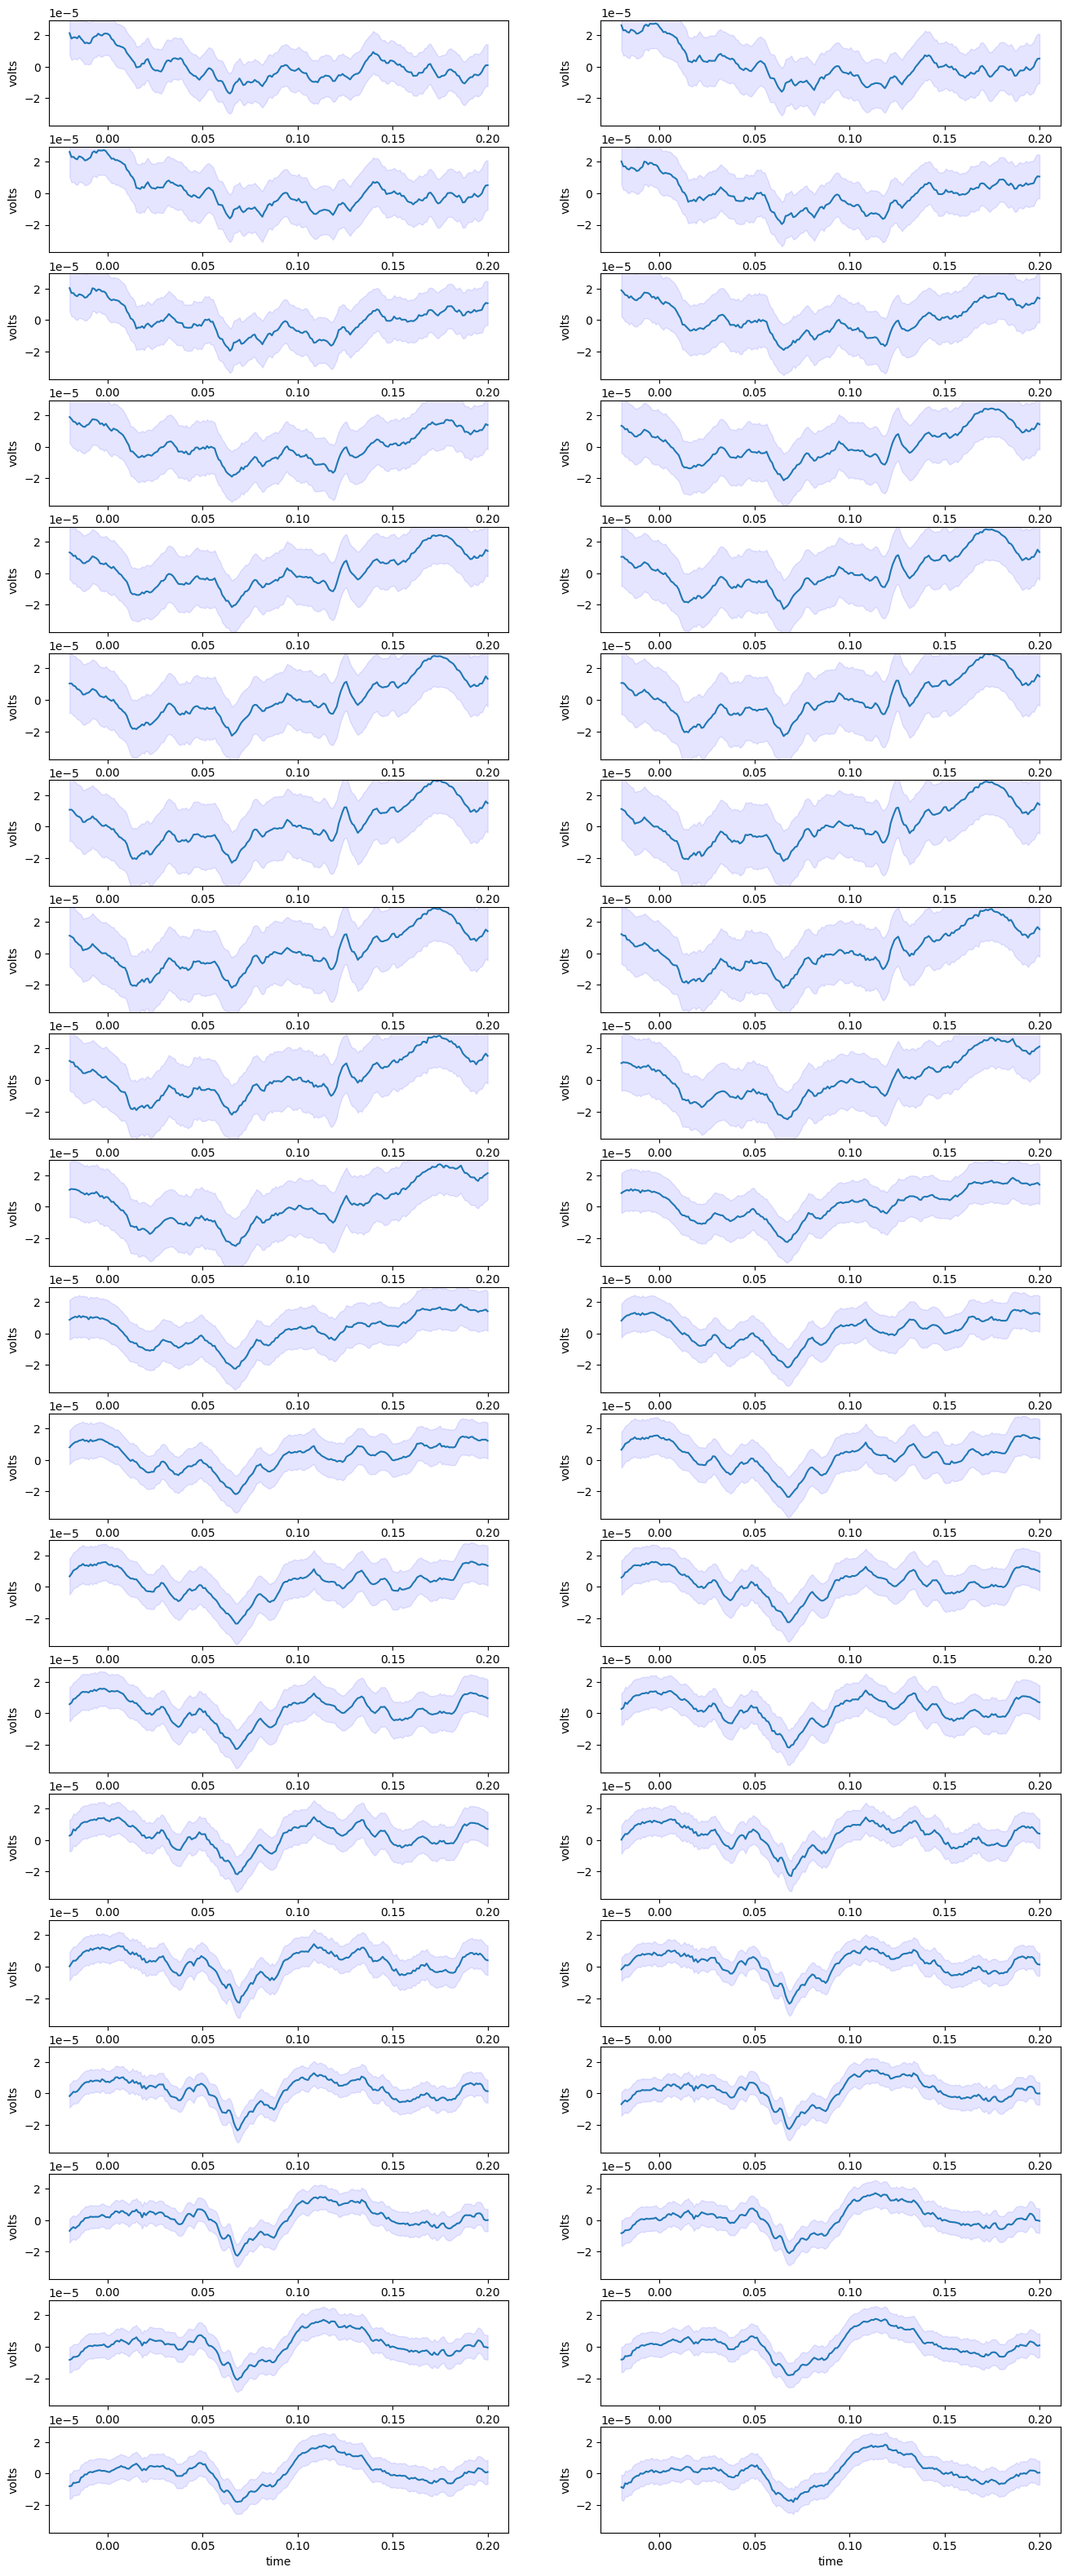

In [37]:
%matplotlib inline

fig, axs = plt.subplots(n_channels//2, 2, figsize=(16, n_channels))
xaxis = np.linspace(start_time, end_time, len(average_trace))

min_yval = np.amin(average_trace[:,start_channel:end_channel])
max_yval = np.amax(average_trace[:,start_channel:end_channel])
upper_bound = average_trace + (ci)
lower_bound = average_trace - (ci)

for i in range(n_channels // 2):
    for j in range(2):
        channel = start_channel + i + j
        ax = axs[i][j]

        ax.plot(xaxis, average_trace[:,channel])
        ax.fill_between(xaxis, lower_bound[:,channel], upper_bound[:,channel], color='b', alpha=.1)
        
        ax.set_ylim([min_yval, max_yval])
        ax.set_ylabel("volts")
        ax.set_xlabel("time")

plt.show()